In [54]:
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd')
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
jtplot.style(ticks=True, grid=False, figsize=(6.5, 5))

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
%matplotlib inline

# 数据探索

## 数据质量分析-异常值、缺失值、一致性分析

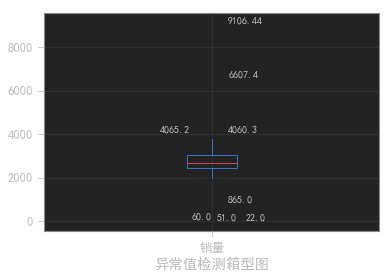

In [346]:
path = "D:\\BaiduNetdiskDownload\\PanDownload\\图书配套数据、代码\\chapter3\\demo\\data\\catering_sale.xls"
catering_data = pd.read_excel(path,index_col='日期')
# catering_data.describe().T
box = catering_data.boxplot(return_type='dict')
plt.xlabel('异常值检测箱型图')
x = box['fliers'][0].get_xdata()
y = box['fliers'][0].get_ydata()
y.sort()
for i in range(len(x)):
    if i>0:
        plt.annotate(y[i],xy=(x[i],y[i]),xytext=(x[i]+0.05-1/(y[i]-y[i-1]),y[i]))
    else:
        plt.annotate(y[i],xy=(x[i],y[i]),xytext=(x[i]+0.1,y[i]))

## 数据特征分析-分布分析、对比分析、统计量分析、周期性分析、贡献度分析(帕累托法则、20/80定律)、相关性分析

In [347]:
#pearson相关系数：要求连续变量的取值服从正态分布
#spearman相关系数：不服从正态分布的变量、分类或等级变量之间的关联可用spearman秩相关系数。
#正态分布假定下,两者等价，对于连续测量数据,pearson相关系数更适合。
# pd.corr(method='pearson/spearman')

# 数据预处理
## 数据清洗
### 缺失值处理-插值法

In [348]:
from scipy.interpolate import lagrange

cater_data = catering_data.reset_index(drop=False)
cater_data[cater_data['销量'].isnull()] #1个缺失值
abnormal = (cater_data['销量']<400) | (cater_data['销量']>5000)
cater_data['销量'][abnormal] = None #过滤异常值，令其为NaN

def interp_column(col,n,k=5): #列向量差值,n为插值点,取前后k=5个数
    col_k = col.reindex(list(range(n-k,n))+list(range(n+1,n+k+1)))
    col_k = col_k[col_k.notnull()]
    return lagrange(col_k.index,list(col_k))(n) #lagrange()返回一个插值函数f(x),(n)代表f(n)

for col in cater_data.columns:
    for i in range(len(cater_data)):
        if (cater_data[col].isnull())[i]:
            catering_data[col][i] = interp_column(cater_data[col],i)
#             print(interp_column(cater_data[col],i))

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## 数据变换-规范化（归一化）

In [349]:
#最大最小规范化
#零均值规范化
#小数定标规范化-移动小数位数将值映射到[-1,1],移动位数取决于属性值绝对值的最大值 
# data/10**np.ceil(np.log10(data.abs().max()))

## 数据变换-离散化

In [350]:
import pandas as pd 
datapath = "D:/BaiduNetdiskDownload/PanDownload/图书配套数据、代码/chapter4/demo/data/discretization_data.xls"
discret_data = pd.read_excel(datapath)
k = 4
labels = ['group%i' %i for i in range(1,k+1)]
#等宽离散化
width_equal = pd.cut(discret_data.iloc[:,0],bins=k,retbins=True,labels=labels)
#等频离散化
q_tile = [i/k for i in range(k+1)]
freq_equal = pd.qcut(discret_data.iloc[:,0],q=q_tile,labels=labels)
#聚类离散化
from sklearn.cluster import KMeans
model = KMeans(n_clusters=k,n_jobs=2)
model.fit(discret_data.iloc[:,0].values.reshape(-1,1))
centers_k = pd.Series(model.cluster_centers_.flatten())
bins = centers_k.rolling(2).mean()[1:]
bins = [0] + sorted(list(bins.values)) + list(discret_data.max())
cluster_disc = pd.cut(discret_data.iloc[:,0],bins=bins,labels=labels)


## 数据规约
### 属性规约
#### 属性合并
#### 逐步向前选择-每次从属性集中选择一个最优属性直到无法选择或满足阈值
#### 逐步向后删除-每次从属性集中剔除一个最差属性直到无法剔除或满足阈值
#### 决策树归纳
#### 主成分分析
### 数值规约
#### 直方图、聚类、抽样、参数回归

# 挖掘建模

## 特征筛选

In [1]:
# from sklearn.feature_selection import f_regression F检验
# from sklearn.feature_selection import RFE,RFECV （交叉验证）递归特征消除 
#  稳定性选择方法：随机逻辑回归与随机Lasso
# from sklearn.linear_model import RandomizedLogisticRegression as RLR 
# from sklearn.linear_model import RandomizedLasso as RLA

## 逻辑回归

In [21]:
import pandas as pd 
datapath = "D:\\BaiduNetdiskDownload\\PanDownload\\图书配套数据、代码\\chapter5\\demo\\data\\bankloan.xls"
data  = pd.read_excel(datapath)
X = data.iloc[:,:8]
y = data.iloc[:,8]

from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import RandomizedLogisticRegression as RLR
#随机逻辑回归deprecated in 0.19 and removed in 0.21.
# 筛选特征
rlr = RLR(selection_threshold=0.25) #默认值
rlr.fit(X,y)
rlr.get_support() #返回bool值/也可用rlr.scores_判断
print('有效特征为:',X.columns[rlr.get_support()])
x = X[X.columns[rlr.get_support()]]
# 模型拟合
lr = LR()
lr.fit(x,y)
print('模型平均正确率为:',lr.score(x,y))

F:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedLogisticRegression is deprecated; The class RandomizedLogisticRegression is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


有效特征为: Index(['工龄', '地址', '负债率', '信用卡负债'], dtype='object')
模型平均正确率为: 0.8142857142857143


## 决策树

In [1]:
import pandas as pd
datapath = "D:\\BaiduNetdiskDownload\\PanDownload\\图书配套数据、代码\\chapter5\\demo\\data\\sales_data.xls"
data = pd.read_excel(datapath,index_col=0)
dic = {'好':1,'是':1,'高':1,'坏':-1,'否':-1,'低':-1}
data = data.replace(dic)
X = data.iloc[:,:3]
y = data.iloc[:,3]

from sklearn.tree import DecisionTreeClassifier as DTC
clf = DTC(criterion='entropy')
clf.fit(X,y)
#决策树可视化
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
export_graphviz(clf,out_file='./treeplot')
# 在treeplot中添加
# digraph Tree{
#     edge [fontname='SimHei'];
#     node [fontname='SimHei']; 
# }
# 在terminal中执行
# dot -Tpdf treeplot.dot -o tree.pdf
# dot -Tpng treeplot.dot -o tree.png
%dot -f svg treeplot

UsageError: Line magic function `%dot` not found.


## 人工神经网络

### 激活函数
1. 阈值函数/阶梯函数: $f(v)=\begin{cases}1\quad v\ge0\\0\quad v<0\end{cases}$
2. 分段线性函数： $f(v)=\begin{cases}1,\quad v\ge1\\v,\quad -1<v<1\\-1,\quad v\le-1\end{cases}$
3. 非线性转移函数：$f(v)=\frac{1}{1+e^{-v}}$
4. Relu函数：$f(v)=\begin{cases}v,\quad v\ge0\\0,\quad v<0\end{cases}$
### 算法
1. BP神经网络
<br>----多层前馈网络，由信号的正向传播与误差的逆向传播两个过程组成，</br><br>学习算法是δ学习规则。只用到了RMSE对权值和阈值的一阶导数（梯度）</br><br>信息，使得算法存在收敛速度缓慢、易陷入局部最小等缺陷。</br>
2. LM神经网络
    <br>基于梯度下降与牛顿法结合的多层前馈网络，迭代次数少收敛快。</br>
3. RBF径向基网络
<br>能够以任意精度逼近任意连续函数，从输入层到隐含层的变换是非线性的，</br>
<br>而从隐含层到输出层的变换是线性的。特别适合于解决分类问题</br>
4. FNN模糊神经网络
<br>输入信号是模糊量，汇集了神经网络与模糊系统的优点，集联想、识别、自适应及模糊信息处理于一体</br>
5. GMDH神经网络
<br>多项式网络，是前馈神经网络中常用的一种用于预测的神经网络</br>
6. ANFIS自适应神经网络
<br>神经网络嵌套在一个全部模糊的结构之中，在不知不觉中向训练数据学习</br>

Epoch 1/1000
34/34 [==============================] - 1s 17ms/step - loss: 0.6669
Epoch 2/1000
34/34 [==============================] - 0s 147us/step - loss: 0.6656
Epoch 3/1000
34/34 [==============================] - 0s 324us/step - loss: 0.6649
Epoch 4/1000
34/34 [==============================] - 0s 176us/step - loss: 0.6635
Epoch 5/1000
34/34 [==============================] - 0s 354us/step - loss: 0.6627
Epoch 6/1000
34/34 [==============================] - 0s 413us/step - loss: 0.6619
Epoch 7/1000
34/34 [==============================] - 0s 236us/step - loss: 0.6611
Epoch 8/1000
34/34 [==============================] - 0s 266us/step - loss: 0.6602
Epoch 9/1000
34/34 [==============================] - 0s 354us/step - loss: 0.6594
Epoch 10/1000
34/34 [==============================] - 0s 471us/step - loss: 0.6585
Epoch 11/1000
34/34 [==============================] - 0s 324us/step - loss: 0.6575
Epoch 12/1000
34/34 [==============================] - 0s 177us/step - loss: 0.6567
Ep

34/34 [==============================] - 0s 324us/step - loss: 0.5184
Epoch 195/1000
34/34 [==============================] - 0s 147us/step - loss: 0.5180
Epoch 196/1000
34/34 [==============================] - 0s 236us/step - loss: 0.5176
Epoch 197/1000
34/34 [==============================] - 0s 147us/step - loss: 0.5168
Epoch 198/1000
34/34 [==============================] - 0s 265us/step - loss: 0.5169
Epoch 199/1000
34/34 [==============================] - 0s 177us/step - loss: 0.5163
Epoch 200/1000
34/34 [==============================] - 0s 206us/step - loss: 0.5157
Epoch 201/1000
34/34 [==============================] - 0s 324us/step - loss: 0.5154
Epoch 202/1000
34/34 [==============================] - 0s 354us/step - loss: 0.5151
Epoch 203/1000
34/34 [==============================] - 0s 147us/step - loss: 0.5146
Epoch 204/1000
34/34 [==============================] - 0s 206us/step - loss: 0.5143
Epoch 205/1000
34/34 [==============================] - 0s 177us/step - loss: 0.

34/34 [==============================] - 0s 177us/step - loss: 0.4710
Epoch 387/1000
34/34 [==============================] - 0s 177us/step - loss: 0.4711
Epoch 388/1000
34/34 [==============================] - 0s 265us/step - loss: 0.4709
Epoch 389/1000
34/34 [==============================] - 0s 206us/step - loss: 0.4707
Epoch 390/1000
34/34 [==============================] - 0s 383us/step - loss: 0.4706
Epoch 391/1000
34/34 [==============================] - 0s 354us/step - loss: 0.4707
Epoch 392/1000
34/34 [==============================] - 0s 177us/step - loss: 0.4703
Epoch 393/1000
34/34 [==============================] - 0s 206us/step - loss: 0.4702
Epoch 394/1000
34/34 [==============================] - 0s 236us/step - loss: 0.4702
Epoch 395/1000
34/34 [==============================] - 0s 177us/step - loss: 0.4700
Epoch 396/1000
34/34 [==============================] - 0s 148us/step - loss: 0.4700
Epoch 397/1000
34/34 [==============================] - 0s 206us/step - loss: 0.

34/34 [==============================] - 0s 236us/step - loss: 0.4567
Epoch 579/1000
34/34 [==============================] - 0s 177us/step - loss: 0.4570
Epoch 580/1000
34/34 [==============================] - 0s 207us/step - loss: 0.4565
Epoch 581/1000
34/34 [==============================] - 0s 147us/step - loss: 0.4565
Epoch 582/1000
34/34 [==============================] - 0s 206us/step - loss: 0.4565
Epoch 583/1000
34/34 [==============================] - 0s 206us/step - loss: 0.4562
Epoch 584/1000
34/34 [==============================] - 0s 206us/step - loss: 0.4565
Epoch 585/1000
34/34 [==============================] - 0s 177us/step - loss: 0.4563
Epoch 586/1000
34/34 [==============================] - 0s 177us/step - loss: 0.4562
Epoch 587/1000
34/34 [==============================] - 0s 265us/step - loss: 0.4562
Epoch 588/1000
34/34 [==============================] - 0s 324us/step - loss: 0.4560
Epoch 589/1000
34/34 [==============================] - 0s 177us/step - loss: 0.

34/34 [==============================] - 0s 147us/step - loss: 0.4514
Epoch 771/1000
34/34 [==============================] - 0s 265us/step - loss: 0.4516
Epoch 772/1000
34/34 [==============================] - 0s 295us/step - loss: 0.4514
Epoch 773/1000
34/34 [==============================] - 0s 295us/step - loss: 0.4514
Epoch 774/1000
34/34 [==============================] - 0s 147us/step - loss: 0.4514
Epoch 775/1000
34/34 [==============================] - 0s 206us/step - loss: 0.4512
Epoch 776/1000
34/34 [==============================] - 0s 148us/step - loss: 0.4513
Epoch 777/1000
34/34 [==============================] - 0s 384us/step - loss: 0.4512
Epoch 778/1000
34/34 [==============================] - ETA: 0s - loss: 0.310 - 0s 266us/step - loss: 0.4510
Epoch 779/1000
34/34 [==============================] - 0s 206us/step - loss: 0.4514
Epoch 780/1000
34/34 [==============================] - 0s 324us/step - loss: 0.4518
Epoch 781/1000
34/34 [==============================] - 

34/34 [==============================] - 0s 265us/step - loss: 0.4494
Epoch 963/1000
34/34 [==============================] - 0s 206us/step - loss: 0.4491
Epoch 964/1000
34/34 [==============================] - 0s 236us/step - loss: 0.4491
Epoch 965/1000
34/34 [==============================] - 0s 177us/step - loss: 0.4492
Epoch 966/1000
34/34 [==============================] - 0s 207us/step - loss: 0.4492
Epoch 967/1000
34/34 [==============================] - 0s 235us/step - loss: 0.4494
Epoch 968/1000
34/34 [==============================] - 0s 206us/step - loss: 0.4490
Epoch 969/1000
34/34 [==============================] - 0s 236us/step - loss: 0.4489
Epoch 970/1000
34/34 [==============================] - 0s 207us/step - loss: 0.4493
Epoch 971/1000
34/34 [==============================] - 0s 206us/step - loss: 0.4491
Epoch 972/1000
34/34 [==============================] - 0s 177us/step - loss: 0.4490
Epoch 973/1000
34/34 [==============================] - 0s 236us/step - loss: 0.

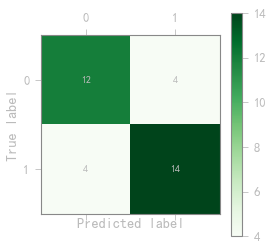

In [20]:
#神经网络预测销量
import pandas as pd
datapath = "D:\\BaiduNetdiskDownload\\PanDownload\\图书配套数据、代码\\chapter5\\demo\\data\\sales_data.xls"
data = pd.read_excel(datapath,index_col=0)
dic = {'好':1,'是':1,'高':1,'坏':0,'否':0,'低':0}
data = data.replace(dic)
X = data.iloc[:,:3]
y = data.iloc[:,3]

from keras.models import Sequential
from keras.layers.core import Dense,Activation

model = Sequential()
model.add(Dense(10,input_shape=(3,))) # 输入层与中间层
model.add(Activation('relu'))
model.add(Dense(1,input_shape=(10,))) # 中间层与输出层
model.add(Activation('sigmoid'))
'''编译模型。由于是二元分类，指定损失函数及模式为binary。
常见损失函数还有mean_squared_error、categorical_crossentropy。
求解方法由adam、sgd、rmsprop'''
model.compile(loss='binary_crossentropy',optimizer='adam')

model.fit(X,y,epochs=1000,batch_size=10) #学习1000次
y_pred = model.predict_classes(X)
#混淆矩阵可视化
def cm_plot(y, yp):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt 
    cm = confusion_matrix(y, yp) 
    plt.matshow(cm, cmap=plt.cm.Greens) 
    plt.colorbar()
    for x in range(len(cm)): 
        for y in range(len(cm)):
            plt.annotate(cm[x,y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
    return plt.show()
cm_plot(y,y_pred)
# Note:神经网路拟合能力很强，容易出现过拟合。与添加惩罚项不同，神经网路通常防止过拟合的方法是随机让部分神经网路节点休眠。

### 分类与预测算法评价
* 绝对误差: $E=Y-\hat{Y}$ 相对误差: $e=\frac{Y-\hat{Y}}{Y}$
* 平均绝对误差： $MAE=\frac{1}{n}\sum_{i=1}^n |Y_i-\hat{Y_i}|$ 
* 均方误差：$MSE=\frac{1}{n}\sum_{i=1}^n E_i^2=\frac{1}{n}\sum_{i=1}^n (Y_i-\hat{Y_i})^2$ 
* 均方根误差：$RMSE=\sqrt{\frac{1}{n}\sum_{i=1}^n E_i^2}=\sqrt{\frac{1}{n}\sum_{i=1}^n (Y_i-\hat{Y_i})^2}$
* 平均绝对百分误差：$MAPE=\frac{1}{n}\sum_{i=1}^n |E_i/Y_i|=\frac{1}{n}\sum_{i=1}^n |(Y_i-\hat{Y_i})/Y_i|$
* Kappa统计：用于比较多个观察者对同一事物，或对同一事物的多次观察结果是否一致。Kappa取值在[-1，1]之间：
    * Kappa=1 说明两次判断结果一致
    * Kappa=-1 完全不一致
    * Kappa=0 说明两次判断结果是机遇造成的
    * Kappa<0 一致度比机遇造成的还差，实际应用无意义
    * Kappa>0 有意义，越大一致性越好
    * Kappa>=0.75 一致程度较好
    * Kappa<0.4 一致程度不够
* 识别准确率
$Accuracy=\frac{TP+FN}{TP+TN+FP+FN}$
* 识别精确率
$Precision=\frac{TP}{TP+FP}$
* 反馈率
$Recall=\frac{TP}{TP+TN}$
* ROC曲线
<p>受试者工作特性（Receiver Operating Characteristic,ROC)曲线，可为选定临界值给出定量提示。
<p>纵轴为灵敏度（Sensitivity），横轴为1-特异性（1-Specificity)
<p>曲线下的面积反映分类器正确分类的统计概率，值越接近于1算法效果越好。
* 混淆矩阵（多少个类别决定几阶矩阵）
<p>   $CM =\begin{bmatrix}cm_{11}\cdots cm_{1n}\\\vdots \ddots \vdots \\cm_{n1} \cdots cm_{nn} \end{bmatrix} $
    * ---混淆矩阵中元素的行下标对应目标真实类别，列下标对应分类器识别的类别；
    * ---对角线元素表示各模式能够被正确识别的百分率，非对角线元素表示错误判别的百分率

### 分类预测模型的特点
* logit回归：分类 sklearn.linear_model
* SVM:回归、预测、分类 sklearn.svm
* 决策树：分类 sklearn.tree
* 随机森林： 分类，精度比决策树高 sklearn.ensemble
* 朴素贝叶斯：分类 sklearn.naive_bayes
* 神经网路：拟合、分类 Keras

## 聚类分析
* 在没有给定划分类别的情况下，根据数据相似度进行样本分组。划分原则是组内距离最小化而组间距离最大化。
* 常用聚类算法
    * K-Means：最小化误差函数；对孤立点比较敏感
    * K-中心点：不采用簇中对象的平均值作为簇中心，而是选用簇中离平均值最近的对象作为簇中心。
    * 系统聚类：多层次聚类，呈树形结构，所处位置越低包含的对象越少，
    <br>但对象间的共同特征越多。只适合小数据量，数据量大时速度较慢。

### K-Means聚类算法
1. 聚类结果依赖于初始聚类中心的随机选择，可能使得结果严重偏离全局最优
2. 对于连续数据聚类中心取簇均值；分类变量均值可能无意义，可使用K-众数方法
3. 连续数据相似性度量：
* n个样本的数据矩阵=
    $\begin{bmatrix}x_{11}\cdots x_{1n}\\\vdots \ddots \vdots \\x_{n1} \cdots x_{nn} \end{bmatrix} $
   * 欧几里得距离：
    <p>$d(i,j)=\sqrt{(x_{i1}-x_{j1})^2+(x_{i2}-x_{j2})^2+...+(x_{ip}-x_{jp})^2}$
   * 曼哈顿距离：
    <p>$d(i,j)=|x_{i1}-x_{j1}|+|x_{i2}-x_{j2}|+...+|x_{ip}-x_{jp}|$
   * 闵可夫斯基距离
    <p>$d(i,j)=\sqrt[q]{(|x_{i1}-x_{j1}|)^q+(|x_{i2}-x_{j2}|)^q+...+(|x_{ip}-x_{jp}|)^q}$ 
* 文档相似度：
<p> $d(i,j)=cos(i,j)=\frac{\vec{i}\cdot\vec{j}}{|\vec{i}||\vec{j}|}$
* 目标函数：误差平方和SSE最小

### 主要聚类算法分类(sklearn.cluster)
* KMeans 
* AffinityPropagation:吸引力传播聚类，几乎优于其他所有方法，不需指定聚类数，缺点是效率较低
* MeanShift:均值漂移聚类算法
* SpectralClustering:谱聚类,效果比K均值好，速度比K均值快
* AgglomerativeClustering:层次聚类，聚类层次树
* DBSCAN：具有噪声的基于密度的聚类法
* BIRCH:综合的层次聚类算法，可以处理大规模数据聚类

### 聚类结果可视化工具(TSNE-数据降维至2/3维空间）
from sklearn.manifold import TSNE

In [84]:
# K-Means聚类
import pandas as pd
datapath = "C:\\Users\win10\\Desktop\\工具文件与命令手册\\数据挖掘文件\\chapter5\\demo\\data\\consumption_data.xls"
data = pd.read_excel(datapath,index_col='Id')
data_msd = (data - data.mean())/data.std() 
k = 3
iteration = 500

from sklearn.cluster import KMeans
model = KMeans(n_clusters=k,n_jobs=4,max_iter=iteration)
model.fit(data_msd)
r1 = pd.Series(model.labels_).value_counts()
r2 = pd.DataFrame(model.cluster_centers_)
r = pd.concat([r2,r1],axis=1)
r.columns = list(data.columns)+['聚类类别']
r
rs = pd.concat([data,pd.Series(model.labels_,index=data.index)],axis=1)
rs.columns = r.columns
rs

# 聚类结果可视化
from sklearn.manifold import TSNE
tsne = TSNE()
tsne.fit_transform(data_msd)
tsne_df = pd.DataFrame(tsne.embedding_,index=data_msd.index)

tsne_d = pd.concat([tsne_df,rs['聚类类别']],axis=1)
cls0 = tsne_d[tsne_d['聚类类别']==0]
plt.plot(cls0[0],cls0[1],'r.')
cls1 = tsne_d[tsne_d['聚类类别']==1]
plt.plot(cls1[0],cls1[1],'go')
cls2 = tsne_d[tsne_d['聚类类别']==2]
plt.plot(cls2[0],cls2[1],'b*')

#密度图
for d in rs.groupby(rs['聚类类别']):
    kde_plot = d[1].iloc[:,:3].plot(kind='kde',linewidth=2,subplots=True,
                                    sharex=False,title='类别%s各属性密度曲线'%d[0])
    [p.set_ylabel('密度') for p in kde_plot]

,R,F,M,聚类类别
Id,,,,
1,27,6,232.61,1
2,3,5,1507.11,1
3,4,16,817.62,2
4,3,11,232.81,1
5,14,7,1913.05,1
6,19,6,220.07,1
7,5,2,615.83,1
8,26,2,1059.66,1
9,21,9,304.82,1


## 关联规则
### 常用关联规则算法
算法名称|描述
---|---
Apriori|通过连接产生候选项及其支持度然后通过剪枝生产频繁项集
FP-Tree|克服Apriori多次扫描事务数据集的缺陷，提出的不产生候选频繁项集的方法
Eclat|深度优先，在概念格理论基础上利用基于前缀的等价关系将搜索空间划分为较小的子空间
灰色关联法|分析和确定各因素之间的影响程度或子因素对主因素的贡献度而进行的一种分析方法
### Apriori算法
* 定义式
    * 支持度:AB同时发生的概率
    <p>$Support(A\Rightarrow B)=P(A\cap B)$
    * 置信度：条件概率
    <p>$Confidence(A\Rightarrow B)=P(B|A)$
* 计算式
    * 绝对支持度/支持度计数/频率/计数
    <p>项集A的支持度计数：事务数据集中包含项集A的的事务个数 
    * $Support(A\Rightarrow B)=\frac{AB同时发生的事务个数\quad\quad\quad}{所有事务个数}=\frac{Support\underline{}count(A\cap B)}{Total\underline{}count(A)}$
    * $Confidence(A\Rightarrow B)=P(A|B)=\frac{Support(A\cap B)}{Support(A)}=\frac{Support\underline{}count(A\cap B)}{Support\underline{}count(A)}$

In [52]:
# Apriori 算法
import pandas as pd
自定义连接函数，用于实现L_{k-1}到C_k的连接
def connect_string(x, ms): #这个函数有问题！！！！！！！！
    x = list(map(lambda i:sorted(i.split(ms)), x))
    l = len(x[0])
    r = []
    for i in range(len(x)):
        for j in range(i,len(x)):
            if x[i][:l-1] == x[j][:l-1] and x[i][l-1] != x[j][l-1]:
                r.append(x[i][:l-1]+sorted([x[j][l-1],x[i][l-1]]))
    return r

#寻找关联规则的函数
def find_rule(d, support, confidence, ms = '--'): #d为原数据矩阵转为的0-1矩阵
    result = pd.DataFrame(index=['support', 'confidence']) #定义输出结果
    support_series = 1.0*d.sum()/len(d) #每一列（项）支持度序列
    column = list(support_series[support_series > support].index) #初步根据支持度筛选
    
    k = 0
    while len(column) > 1:
        k = k+1
        print('正在进行第%s次搜索...' %k)
        column = connect_string(column, ms)
        print('数目：%s...' %len(column))
        sf = lambda i: d[i].prod(axis=1, numeric_only = True) #新一批支持度的计算函数
    
    #创建连接数据，这一步耗时、耗内存最严重。当数据集较大时，可以考虑并行运算优化。
    d_2 = pd.DataFrame(list(map(sf,column)), index = [ms.join(i) for i in column]).T
    
    support_series_2 = 1.0*d_2[[ms.join(i) for i in column]].sum()/len(d) #计算连接后的支持度
    column = list(support_series_2[support_series_2 > support].index) #新一轮支持度筛选
    support_series = support_series.append(support_series_2)
    column2 = []
    
    for i in column: #遍历可能的推理，如{A,B,C}究竟是A+B-->C还是B+C-->A还是C+A-->B？
        i = i.split(ms)
        for j in range(len(i)):
            column2.append(i[:j]+i[j+1:]+i[j:j+1])
    
    cofidence_series = pd.Series(index=[ms.join(i) for i in column2]) #定义置信度序列
    
    for i in column2: #计算置信度序列
        cofidence_series[ms.join(i)] = support_series[ms.join(sorted(i))]/support_series[ms.join(i[:len(i)-1])]
    
    for i in cofidence_series[cofidence_series > confidence].index: #置信度筛选
        result[i] = 0.0
        result[i]['confidence'] = cofidence_series[i]
        result[i]['support'] = support_series[ms.join(sorted(i.split(ms)))]
        
    result = result.T.sort(['confidence','support'], ascending = False) #结果整理，输出
    print(u'\n结果为：')
    print(result)

    return result

# example
import pandas as pd
datapath = "C:\\Users\\win10\\Desktop\\工具文件与命令手册\\数据挖掘文件\\chapter5\\demo\\data\\menu_orders.xls"
data = pd.read_excel(datapath,header=None)

print('转换原始数据至0-1矩阵...')
ct = lambda x: pd.Series(1,index=x[pd.notnull(x)])
b = map(ct,data.as_matrix())
f_data = pd.DataFrame(list(b)).fillna(0)
print('转换完毕')
del b

support = 0.2
confidence = 0.5
ms = '---'
find_rule(f_data,support,confidence,ms)

转换原始数据至0-1矩阵...
转换完毕
正在进行第1次搜索...
数目：6...
正在进行第2次搜索...
数目：54...
正在进行第3次搜索...
数目：4374...
正在进行第4次搜索...
数目：28697814...
正在进行第5次搜索...


KeyboardInterrupt: 

## 时间序列分析
### 常用时间序列模型
模型名称|描述|平稳性质
---|---|---
平滑法|移动平均与指数平均法：削弱短期随机波动对序列的影响|
AR|$X_t=\phi_0 +\phi_1 X_{t-1}+\phi_2 X_{t-2}+\cdots+\phi_p X_{t-p}+\varepsilon_t$|常均值、常方差、ACF拖尾、PACF截尾(p阶)
MA|$X_t=\mu+\varepsilon_t+\theta_1\varepsilon_{t-1}+\theta_2\varepsilon_{t-2}+\cdots+\theta_q\varepsilon_{t-q}$|常均值、常方差、ACF（q阶截尾）、PACF拖尾
ARMA|$X_t=\phi_0 +\phi_1 X_{t-1}+\phi_2 X_{t-2}+\cdots+\phi_p X_{t-p}+\varepsilon_t+\theta_1\varepsilon_{t-1}+\theta_2\varepsilon_{t-2}+\cdots+\theta_q\varepsilon_{t-q}$|常均值、常方差、ACF拖尾（p）、PACF拖尾（q）
ARIMA|差分平稳序列|
ARCH|能准确模拟时序的波动性变化，适用于序列具有短期自相关异方差函数|
GARCH|比ARCH更能反映序列的长期记忆性、信息的非对称性等性质|
### 平稳性
* 序列分类
    1. 白噪声序列：纯随机序列，序列各项没有任何相关关系，是没有任何信息可提取的平稳序列
    2. 平稳非白噪声：均值与方差是常数
    3. 非平稳序列：均值与方差不稳定
* 平稳性检验
    1. 时序图检验：平稳序列始终在一个常数附近随机波动，若有趋势性或者周期性就不平稳
    2. 自相关图检验：平稳序列具有短期相关性，随着期数k的增加，自相关系数$\rho_k$会比较快的衰减趋于0，并在0附近随机波动；非平稳序列自相关系数衰减速度比较慢。
    3. 单位根检验：存在单位根，非平稳。原假设存在单位根。
    4. 白噪声检验：自协方差为0，实际只能接近0.可用Q统计量、LB统计量检验，原假设为纯随机序列。

### 相关函数
模块位置|使用格式
---|---
statsmodels.tsa.stattools|acf(ts,unbiased=False,nlags=40,qtat=False,fft=False,alpha=None) #ts可以是DataFrame或Series
statsmodels.tsa.stattools|pacf()
statsmodels.graphics.tsaplots|plot_pcf(data)/plot_pacf()
statsmodels.tsa.stattools|adfuller(ts,maxlag=None,regression='c',autolag='AIC',store=False,regresults=False)
pandas|diff()
statsmodels.tsa.arima_model|arima=ARIMA(data,(p,d,q).fit()
arima|arima.summary()/arima.summary2()/arima.aic/ arima.bic/ arima.hqic/ f_value,f_error,f_CI=arima.forecast(n)
statsmodels.stats.diagnostic|acorr_ljungbox(data,lags=1)





(1.8137710150945274,
 0.9983759421514264,
 10,
 26,
 {'1%': -3.7112123008648155,
  '5%': -2.981246804733728,
  '10%': -2.6300945562130176},
 299.46989866024177)

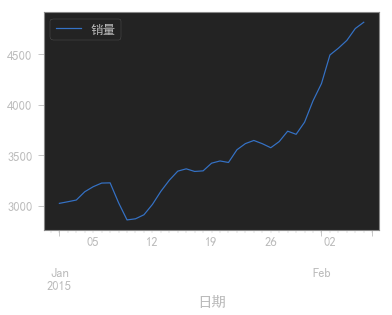

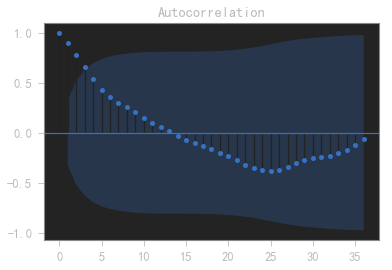

In [68]:
# ARIMA模型实例
import pandas as pd
datapath = "C:\\Users\win10\\Desktop\\工具文件与命令手册\\数据挖掘文件\\chapter5\\demo\\data\\arima_data.xls"
data = pd.read_excel(datapath,index_col='日期')
#时序图
data.plot()
#自相关图
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(data)
#平稳性检验
from statsmodels.tsa.stattools import adfuller as ADF
ADF(data['销量']) #返回ADF值、p值、滞后期、观测值计数、临界值、ic值

#差分
data_diff=pd.DataFrame(data.diff()).dropna()
data_diff.rename(columns={'销量':'销量差分'},inplace=True)
data_diff.plot()
plot_acf(data_diff)
plot_pacf(data_diff)
ADF(data_diff['销量差分'])

#白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(data_diff,lags=1)

from statsmodels.tsa.arima_model import ARIMA
#定阶
pmax=int(len(data_diff)/10) #一般阶数不超过len/10
qmax = int(len(data_diff)/10)
bic_matrix = [] 
for p in range(pmax+1):
    bic = []
    for q in range(qmax+1):
        try:
            bic.append(ARIMA(data.astype(float),(p,1,q)).fit().bic)
        except:
            bic.append(None)
    bic_matrix.append(bic)
bic_matrix = pd.DataFrame(bic_matrix)
p,q=bic_matrix.stack().idxmin() #最小pq值
model = ARIMA(data.astype(float),(p,1,q)).fit() #arima模型数据必须时float类型
model.summary2()
model.forecast(5) #返回预测值、标准误、置信区间

## 离群点检测

### 离群点检测方法
方法|方法描述|方法评价
---|---|---
基于统计模型|构建一个概率分布模型，把低概率对象视为离群点|前提是必须知道服从的分布；对高维数据检验效果可能很差
基于临近度|定义临近性，把远离大部分数据点的对象视为离群点|大数据集不适用；对参数选择敏感；不能处理具有不同密度区域的数据集
基于密度|离群点是低密度区域中的对象；离群点得分是该对象周围密度的逆|大数据集不适用；参数选择困难
基于聚类|先聚类，然后评估对象属于簇的程度（离群点得分）|可能很有效；簇的质量对离群点的质量影响非常大
|note：*基于密度与基于临近度的方法密切相关：密度常用临近度定义。一种是到K个最邻近对象的平均距离的倒数，距离越小则密度越高；另一种是DBSCAN聚类算法，一个对象周围的密度等于该对象指定距离d内对象的个数。|
|note：*评估对象属于簇的程度（离群点得分）：一种是度量对象到簇中心的距离；而是考虑簇具有不同密度，可以度量对象到簇的相对距离——点到质心的距离与簇中所有点到质心的距离的中位数之比。|

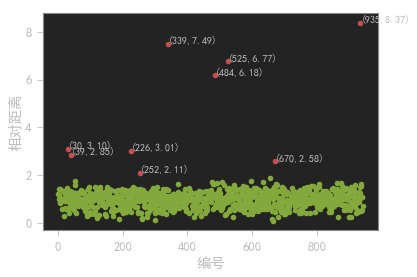

In [114]:
#聚类离群点检验
import numpy as np
import pandas as pd
datapath = "C:\\Users\\win10\\Desktop\\工具文件与命令手册\\数据挖掘文件\\chapter5\\demo\\data\\consumption_data.xls"
k = 3
threshold = 2 #离散点阈值
iteration = 500
data = pd.read_excel(datapath,index_col='Id')
data_msd = (data-data.mean())/data.std()

from sklearn.cluster import KMeans
model = KMeans(n_clusters=k,n_jobs=4,max_iter=iteration)
model.fit(data_msd)
r = pd.concat([data_msd,pd.Series(model.labels_,index=data.index)],axis=1)
r.columns = list(data.columns)+['聚类类别']

norm =[]
for i in range(k):
    norm_tmp = r[['R','F','M']][r['聚类类别']==i]-model.cluster_centers_[i]
    norm_tmp = norm_tmp.apply(np.linalg.norm,axis=1) #求绝对距离
    norm.append(norm_tmp/norm_tmp.median())
norm = pd.concat(norm)
norm[norm<=threshold].plot(style='go')
discrete_points = norm[norm>threshold]
discrete_points.plot(style='ro')

for i in range(len(discrete_points)):
    id = discrete_points.index[i]
    n = discrete_points.iloc[i]
    plt.annotate('(%s,%0.2f)'%(id,n),xy=(id,n),xytext=(id,n))
plt.xlabel('编号')
plt.ylabel('相对距离')
plt.show()